In [1]:
from copy import deepcopy
import os
import pathlib
import sys

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.data.generator import ClassicGenerator
from endure.lcm.model.builder import LearnedCostModelBuilder
from endure.lsm.cost import EndureCost
from endure.lsm.solver import EndureLevelSolver, ClassicSolver
from endure.lsm.types import Policy, System, LSMDesign
from endure.ltune.loss import LearnedCostModelLoss
from endure.ltune.model.builder import LTuneModelBuilder

# Loading Model

In [4]:
path = '/data/models/ltune/classic-05-22-v3/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
# config = Reader.read_config('../../endure.toml')
cf = EndureCost(config)

In [5]:
model = LTuneModelBuilder(config).build_model()
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_09.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
# status

ClassicTuner(
  (policy): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (bits): Linear(in_features=256, out_features=1, bias=True)
  (size_ratio): Linear(in_features=256, out_features=49, bias=True)
  (layers): Sequential(
    (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=9, out_features=256, bias=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=256, out_features=256, bias=True)
    (14): 

In [6]:
def convert_model_out_to_design(output):
    output = output.flatten()
    policy = np.around(output[0].item())
    policy = Policy.Leveling if policy == 1 else Policy.Tiering
    h = output[1].item()
    size_ratio = torch.argmax(output[2:]).item() + config['lsm']['size_ratio']['min']
    design = LSMDesign(h=h, T=size_ratio, policy=policy)

    return design

In [7]:
def get_model_design(system, z0, z1, q, w):
    x = torch.Tensor([z0, z1, q, w, system.B, system.s, system.E, system.H, system.N])
    x = x.view(1, -1)
    out = model(x, temp=1e-3, hard=False)
    design = convert_model_out_to_design(out)
    
    return design, out

In [8]:
gen = ClassicGenerator(config)
system = System()
z0, z1, q, w = gen._sample_workload(4)
design, out = get_model_design(system, z0, z1, q, w)
design, out

(LSMDesign(h=1.701999545097351, T=4, policy=<Policy.Leveling: 1>, Q=1.0, Y=1.0, Z=1.0, K=[]),
 tensor([[0.7520, 1.7020, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
        grad_fn=<CatBackward0>))

# Training Loss

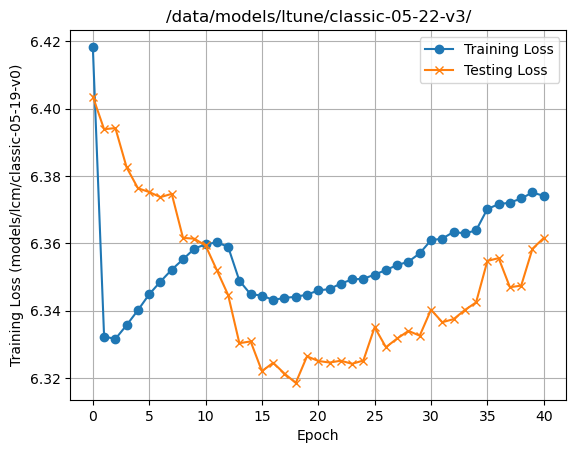

In [9]:
losses = pd.read_csv(os.path.join(path, 'losses.csv')).loc[0:40]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], '-o', label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], '-x', label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LTuneTrain"]["loss_fn_path"]})')
ax.set_title(f'{path}')
ax.grid()
_ = ax.legend()

# Loading Learned Cost Model

In [10]:
loss = LearnedCostModelLoss(config, config["job"]["LTuneTrain"]["loss_fn_path"])
loss.eval()
loss_model = loss.model
loss_model.eval()

ClassicModel(
  (embedding): Sequential(
    (0): Linear(in_features=49, out_features=128, bias=True)
  )
  (cost_layer): Sequential(
    (0): BatchNorm1d(139, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=139, out_features=512, bias=True)
    (2): Dropout(p=0, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Dropout(p=0, inplace=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Dropout(p=0, inplace=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Dropout(p=0, inplace=False)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=512, out_features=4, bias=True)
    (14): LeakyReLU(negative_slope=0.01)
  )
)

In [17]:
def eval_lcm(design, system, z0, z1, q, w):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = design.T - config['lsm']['size_ratio']['min']
    T = np.eye(categories, dtype=np.int32)[int(np.ceil(T))]
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.policy.value, design.h]
    if "policy" not in config["lcm"]["input_features"]:
        feats.pop(-2)
    inputs = np.concatenate((np.array(feats), T))
    inputs = torch.from_numpy(inputs).to(torch.float).view(1, -1)
    with torch.no_grad():
        pred = loss_model(inputs)
        pred = pred.sum().item()
    return pred

In [18]:
def eval_lcm_direct(model_out, system, z0, z1, q, w):
    label = torch.Tensor([z0, z1, q, w, system.B, system.s, system.E, system.H, system.N]).view(1, -1)
    inputs = torch.concat([label, model_out], dim=-1)
    with torch.no_grad():
        pred = loss_model(inputs)
        pred = pred.sum().item()
    return pred

In [19]:
def eval_acm(design, system, wl):
    h, T = design
    B, s, E, H, N = system
    z0, z1, q, w = wl
    
    cfg = deepcopy(config)
    cfg["lsm"]["system"]["B"] = B
    cfg["lsm"]["system"]["s"] = s
    cfg["lsm"]["system"]["E"] = E
    cfg["lsm"]["system"]["H"] = H
    cfg["lsm"]["system"]["N"] = N
    cost = Cost.EndureLevelCost(cfg)

    return cost(h, T, z0, z1, q, w)

In [20]:
def get_system(cfg):
    B = cfg["lsm"]["system"]["B"]
    s = cfg["lsm"]["system"]["s"]
    E = cfg["lsm"]["system"]["E"]
    H = cfg["lsm"]["system"]["H"]
    N = cfg["lsm"]["system"]["N"]
    return (B, s, E, H, N)

# Evaluation

In [21]:
def eval_rand_workloads(num_wls=5000, system=None):
    cfg = deepcopy(config)
    if system is None:
        system = System()
    
    table = [] 
    for _ in tqdm(range(num_wls)):
        wl = np.array(gen._sample_workload(4))
        z0, z1, q, w = wl
        system = gen._sample_system()
        solver = ClassicSolver(cfg)
        
        # eval normal
        stune_design, sol = solver.get_nominal_design(system, z0, z1, q, w)
        stune_loss = eval_lcm(stune_design, system, z0, z1, q, w)
        stune_cost = cf.calc_cost(stune_design, system, z0, z1, q, w)
        
        # eval learned
        ltune_design, out = get_model_design(system, z0, z1, q, w)
        ltune_loss_indirect = eval_lcm(ltune_design, system, z0, z1, q, w)
        ltune_loss = eval_lcm_direct(out, system, z0, z1, q, w)
        ltune_cost = cf.calc_cost(ltune_design, system, z0, z1, q, w)
        
        row = {
            'z0': z0,
            'z1': z1,
            'q': q,
            'w': w,
            'B': system.B,
            's': system.s,
            'E': system.E,
            'H': system.H,
            'N': system.N,
            'stune_policy': stune_design.policy.value,
            'stune_h': stune_design.h,
            'stune_T': stune_design.T,
            'stune_cost': stune_cost,
            'stune_loss': stune_loss,
            'ltune_policy': ltune_design.policy.value,
            'ltune_h': ltune_design.h,
            'ltune_T': ltune_design.T,
            'ltune_cost': ltune_cost,
            'ltune_loss': ltune_loss_indirect,
            'ltune_loss_indirect': ltune_loss,
        }
        table.append(row)
    
    return pd.DataFrame(table)

In [22]:
np.random.seed(0)
df = eval_rand_workloads(num_wls=3000)
df['delta_cost'] = (df['stune_cost'] - df['ltune_cost']) / df['stune_cost']
df['delta_loss'] = (df['stune_loss'] - df['ltune_loss']) / df['stune_loss']
df['stune_diff'] = (df['stune_cost'] - df['stune_loss']) / df['stune_cost']
df['ltune_diff'] = (df['ltune_cost'] - df['ltune_loss']) / df['ltune_cost']

  0%|          | 0/3000 [00:00<?, ?it/s]

In [50]:
cols = ['z0', 'z1', 'q', 'w',
        'stune_policy', 'stune_h', 'stune_T',
        'ltune_policy', 'ltune_h', 'ltune_T',
        'stune_cost', 'ltune_cost',
        'stune_loss', 'ltune_loss', 'ltune_loss_indirect',
        'delta_cost', 'delta_loss',
        'stune_diff', 'ltune_diff']
df.sort_values(by='delta_cost', ascending=True).head(20)[cols]

,z0,z1,q,w,stune_policy,stune_h,stune_T,ltune_policy,ltune_h,ltune_T,stune_cost,ltune_cost,stune_loss,ltune_loss,ltune_loss_indirect,delta_cost,delta_loss,stune_diff,ltune_diff
2028,0.623,0.310,0.001,0.066,0,9.900000,6.652679,1,9.720169,50,0.615252,1.843793,0.617841,1.380998,0.959520,-1.996810,-1.235200,-0.004208,0.251002
2654,0.304,0.483,0.070,0.143,1,6.720015,4.434842,1,7.565777,50,1.832866,3.998499,1.801173,2.718457,1.389308,-1.181556,-0.509270,0.017291,0.320131
1126,0.312,0.508,0.014,0.166,0,5.307152,4.124861,1,4.501514,50,3.323269,6.855346,3.328110,5.087409,4.608101,-1.062832,-0.528618,-0.001457,0.257892
1912,0.529,0.221,0.088,0.162,1,6.060152,4.626419,1,2.809178,50,2.655297,5.109870,2.651603,3.565558,1.748104,-0.924406,-0.344680,0.001391,0.302221
1653,0.324,0.534,0.031,0.111,1,5.658270,4.006082,1,6.135069,50,2.249912,4.276400,2.217256,3.123445,1.554342,-0.900697,-0.408699,0.014514,0.269609
2579,0.494,0.164,0.146,0.196,1,6.726013,5.063377,1,7.566756,50,3.329256,6.053632,3.291303,4.232802,2.473009,-0.818314,-0.286057,0.011400,0.300783
3,0.520,0.159,0.122,0.199,1,5.764665,4.788111,1,2.720869,50,3.829957,6.758451,3.790395,4.927845,3.153903,-0.764628,-0.300088,0.010330,0.270862
642,0.113,0.631,0.123,0.133,1,4.433880,5.672284,1,6.127703,50,2.731714,4.693993,2.706609,3.450473,2.092512,-0.718332,-0.274833,0.009190,0.264917
2358,0.313,0.452,0.037,0.198,0,8.395235,3.881117,1,6.905346,50,5.094025,8.463023,5.080063,6.779628,4.520994,-0.661363,-0.334556,0.002741,0.198912
423,0.194,0.597,0.070,0.139,1,4.323424,4.686357,1,5.365631,50,3.834466,6.254904,3.793469,4.838458,3.028510,-0.631232,-0.275470,0.010692,0.226454


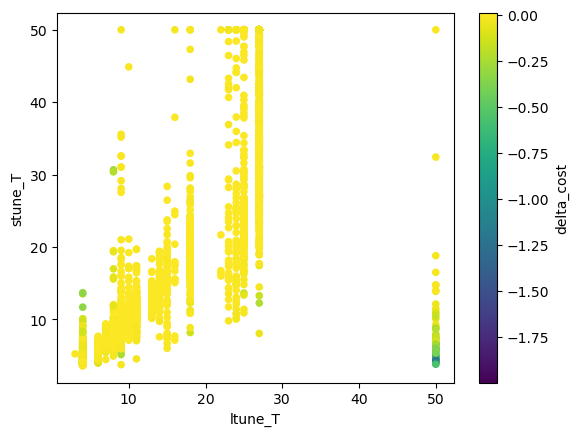

In [24]:
ax = df.plot.scatter(x='ltune_T', y='stune_T', c='delta_cost', cmap='viridis')

## Analytical Cost Model

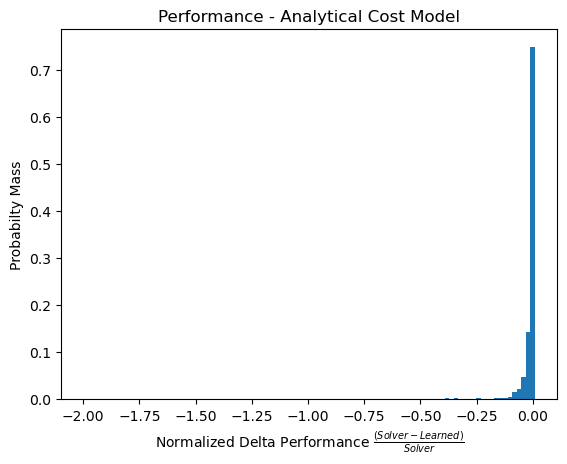

In [44]:
fig, ax = plt.subplots()
data = df['delta_cost']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), alpha=1, density=False, label='ACM', color='tab:blue')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
ax.set_title('Performance - Analytical Cost Model')
# ax.legend()
plt.show()

## Learned Cost Model

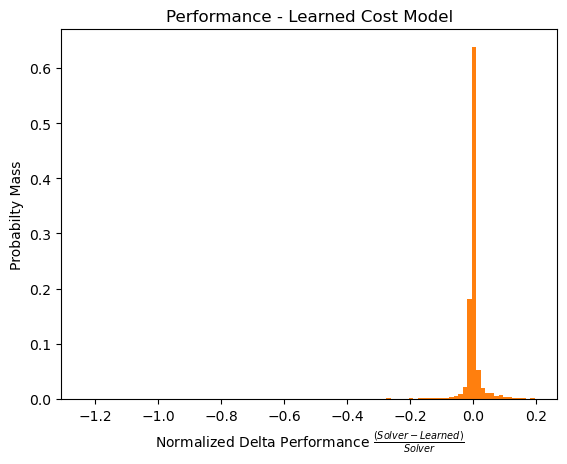

In [43]:
fig, ax = plt.subplots()
data = df['delta_loss']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), density=False, color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
ax.set_title('Performance - Learned Cost Model')
plt.show()

## Difference in ACM and LCM

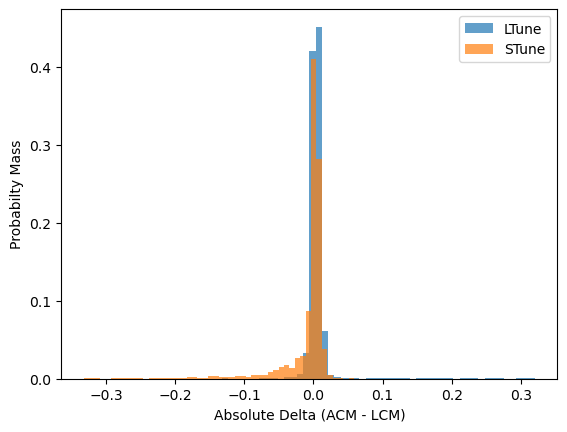

In [45]:
fig, ax = plt.subplots()
ldata = df['ltune_diff']
sdata = df['stune_diff']
ax.hist(ldata, weights=np.ones_like(ldata)/len(ldata), bins=50, alpha=0.7, label='LTune', color='tab:blue')
ax.hist(sdata, weights=np.ones_like(sdata)/len(sdata), bins=50, alpha=0.7, label='STune', color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()

In [46]:
df['ltune_mbuff'] = ((df['H'] - df['ltune_h']) * df['N']) / (1 * 1024 * 1024 * 1024 * 8)

## Workload Correlations

In [47]:
def plot_workload_trend(trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

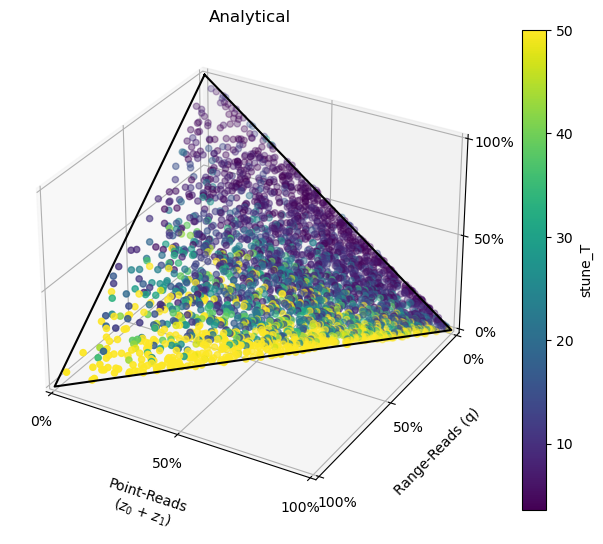

In [48]:
fig, ax, sc, cbar = plot_workload_trend(trend='stune_T')
ax.set_title('Analytical')
plt.show()

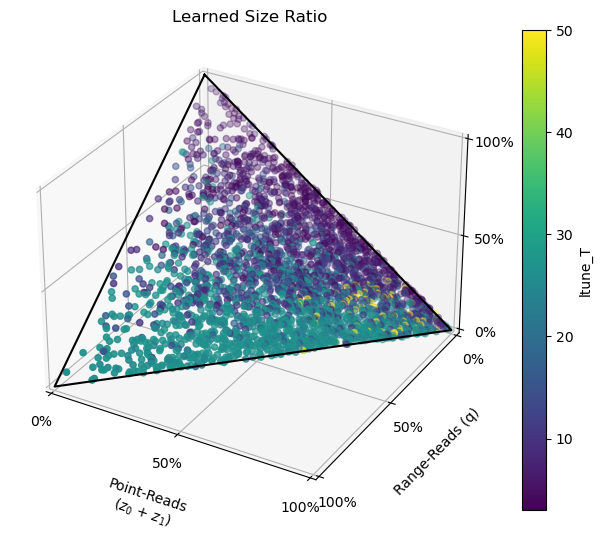

In [49]:
fig, ax, sc, cbar = plot_workload_trend(trend='ltune_T')
ax.set_title('Learned Size Ratio')
plt.show()

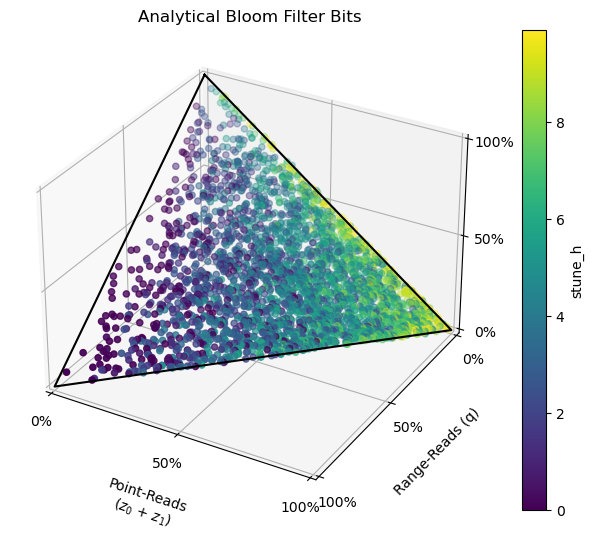

In [32]:
fig, ax, sc, cbar = plot_workload_trend(trend='stune_h')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

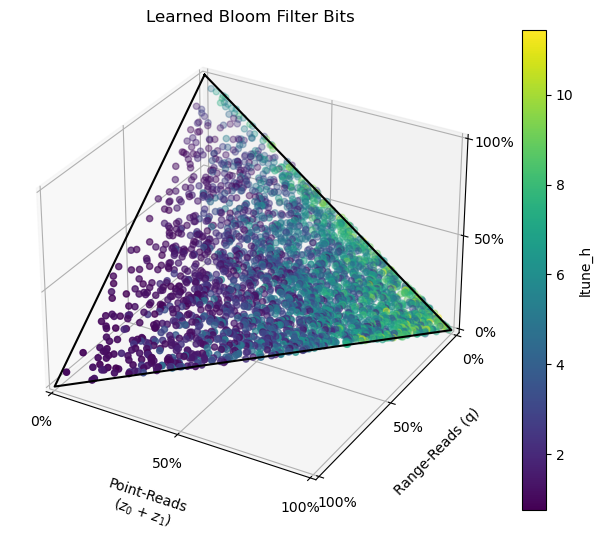

In [33]:
fig, ax, sc, cbar = plot_workload_trend(trend='ltune_h')
ax.set_title('Learned Bloom Filter Bits')
plt.show()

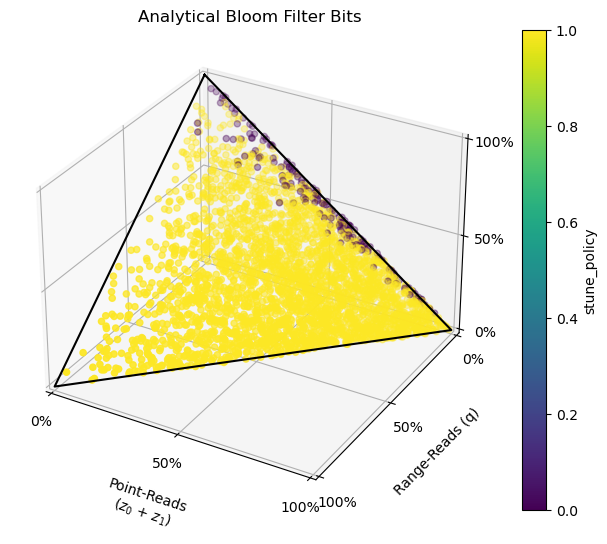

In [34]:
fig, ax, sc, cbar = plot_workload_trend(trend='stune_policy')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

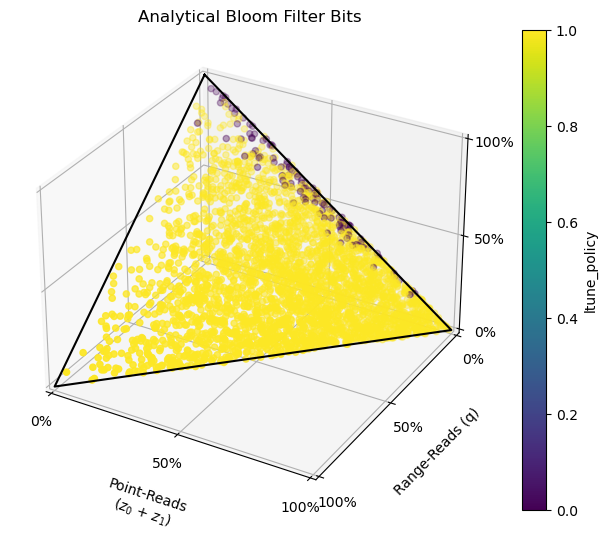

In [35]:
fig, ax, sc, cbar = plot_workload_trend(trend='ltune_policy')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

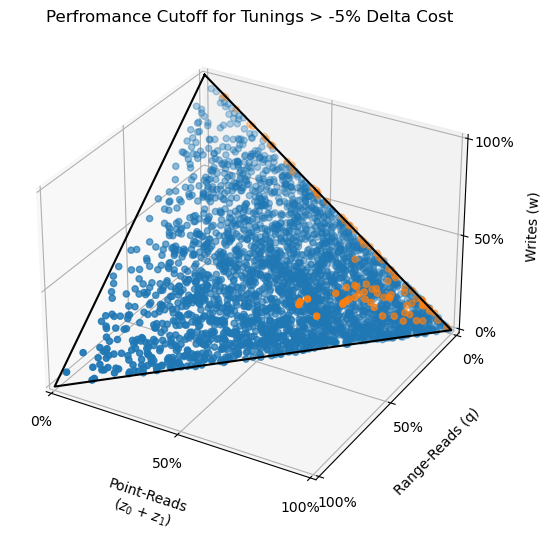

In [40]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

cutoff = (-0.05)
groupa = df[df['delta_loss'] > cutoff]
groupb = df[df['delta_loss'] < cutoff]
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Decent')
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Poor')
ax.set_title(f'Perfromance Cutoff for Tunings > {cutoff:.0%} Delta Cost')
plt.show()

In [37]:
def bias_sample(dimensions=4):
    max_non_writes = np.random.rand() * 0.5
    workload = list(np.random.rand(dimensions - 1) * max_non_writes) + [0, 1]
    workload.sort()
    workload = [b - a for a, b in zip(workload, workload[1:])]
    
    return workload

In [ ]:
a = torch.Tensor([1.5])
a.requires_grad_()
b = torch.round(a)
b

In [ ]:
b.backward()
a.grad